In [161]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
from natsort import natsorted
import os
import re

In [235]:
PX_PER_MM = 7.532343134764206
FRAME_PER_SECOND = 60

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

## x(t)

In [227]:
df_x_t = pd.read_csv('datos\\ECO20-45mm\\cabeza\\1,00Vpp-3Hz.csv')
v = '1,00Vpp' 
vval = 1.0
f = '3Hz'
t,x,y = np.array(df_x_t['t']/FRAME_PER_SECOND), np.array(df_x_t['x']/PX_PER_MM), df_x_t['y']/PX_PER_MM
x = -x + np.max(x)
# x_recentered = x - (x[0]-avg_start)

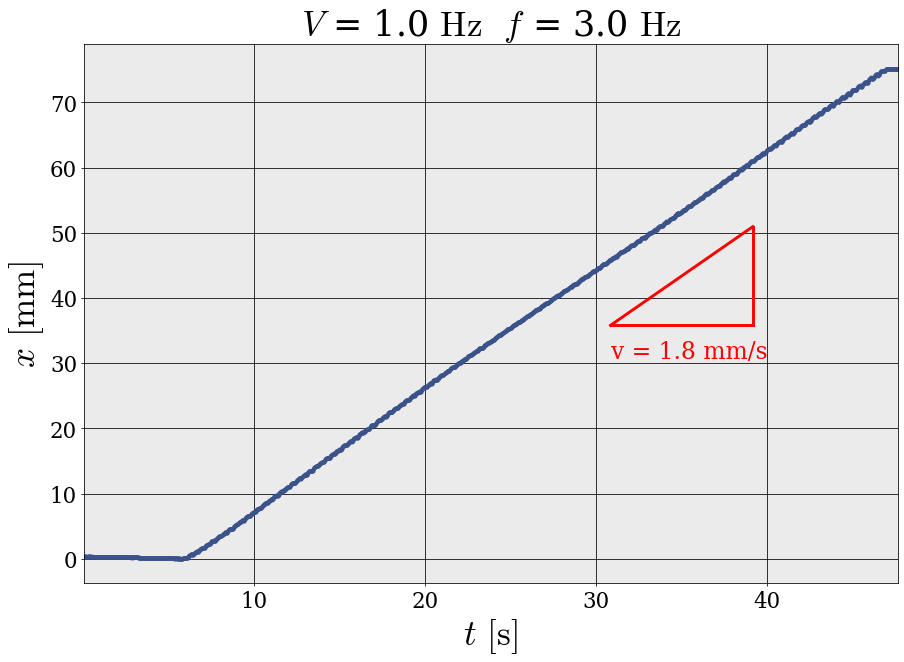

In [252]:
norm = plt.Normalize(0.5,2.5)
cmap = plt.colormaps.get_cmap('viridis')
colorscale = plt.cm.ScalarMappable(norm, cmap)



fig, ax = plt.subplots()
ax.plot(t, x, '.', color = cmap(norm(vval)))

# SLOPE

t_mid = np.array([t[1850], t[2350]])
x_mid = np.array([x[1850]-10, x[2350]-10])

# Calculate slope
slope = np.diff(x_mid) / np.diff(t_mid)

ax.plot(t_mid, x_mid, color='r', lw=3)
ax.plot([t_mid[0], t_mid[1]], [x_mid[0], x_mid[0]], color='r', lw=3)
ax.plot([t_mid[1], t_mid[1]], [x_mid[0], x_mid[1]], color='r', lw=3)

ax.text(t_mid[0], x_mid[0]-5, f'v = {round(slope[0], 1)} mm/s', fontsize=24, color='r')


# INSET AXES
# x1, x2, y1, y2 = t[275], t[425], x[275]-1, x[425]  # subregion of the original image

# axins = ax.inset_axes(
#     [0.08, 0.5, 0.40, 0.4],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# axins.plot(t[275:425], x[275:425], '.', color = cmap(norm(vval)))
# axins.grid(None)
# ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_title(f'$V$ = 1.0 $\\text{{Hz}}$  $f$ = 3.0 $\\text{{Hz}}$')
ax.set_xlabel(f'$t$ $[\\text{{s}}]$')
ax.set_ylabel(f'$x$ $[\\text{{mm}}]$')

# fig.savefig(f'gráficos\\x(t)_1Vpp_3Hz.png')

## Velocidad terminal en función de f y V

### Pendientes para la cabeza

In [220]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = [filepath for filepath in os.listdir('datos\\ECO20-45mm\\cabeza pendiente') if '.csv' in filepath]
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'datos\\ECO20-45mm\\cabeza pendiente\\{f}') for f in filenamelist['name']]


In [224]:
f_lineal = lambda x,a,b: a*x + b

FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7,33Hz','7,66Hz','8Hz','9Hz','10Hz']
# FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','8Hz','9Hz','10Hz']
VOLT_ARRAY = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

FREQ_ARRAY_VALUES = [2,3,4,5,6,7,7.33,7.66,8,9,10]
# FREQ_ARRAY_VALUES = [2,3,4,5,6,7,8,9,10]
VOLT_ARRAY_VALUES = [0.5,1,1.5,2,2.5]

#Creating the colormap
norm_v = plt.Normalize(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(FREQ_ARRAY_VALUES[0],FREQ_ARRAY_VALUES[-1])
cmap_f = plt.colormaps.get_cmap('viridis')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

# currVolt_array = ['500mVpp','1,00Vpp','1,50Vpp','2,00Vpp','2,50Vpp'] #We create a volt tag array

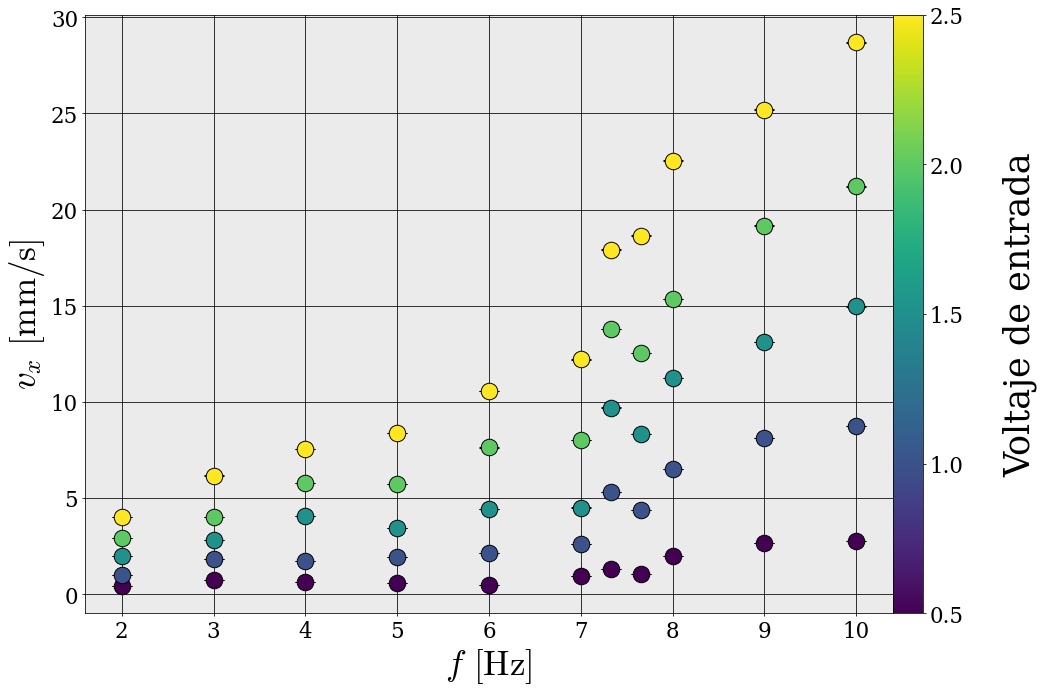

In [225]:
fig, ax = plt.subplots()

values_dict = dict({})
error_dict = dict({})
currHz_array = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7,33Hz','7,66Hz','8Hz','9Hz','10Hz'] #We create a frecuency array
# currHz_array = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz', '8Hz','9Hz','10Hz']

for currHz in currHz_array:
    
    filtered_namelist = [name for name in csv_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files

    # df_namelist = filenamelist[filenamelist['name'].str.contains(currVolt)] #We get the filenames corresponding to the voltage chosen
    # filtered_namelist = df_namelist['name'] #We get the names of those files

    values_dict[f'{currHz}'] = np.array([])
    error_dict[f'{currHz}'] = np.array([])

    for filename in filtered_namelist:
        df_txy = df[csv_names.index(filename)] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        # print(f' {v}-{f} => parametros: {popt[0]}, {popt[1]} ; errores: {err_popt[0]}, {err_popt[1]} ')
        
        values_dict[f'{currHz}'] = np.append(values_dict[f'{currHz}'],(popt[0]))
        error_dict[f'{currHz}'] = np.append(error_dict[f'{currHz}'],(err_popt[0]))
        # Plotting
        ax.errorbar(fval, np.abs(popt[0]), markerfacecolor = volt_color, fmt='o',
                    yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                    ms=17, elinewidth=2, lw=3, capsize=10)

        
# Colorbar configuration

cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)


# cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0)
# cbar_term.ax.set_ylim(2,10)
# cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
# cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)


#Axes configuration
ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()
# fig.savefig('gráficos\\slope(f,V) sin 3366.png')
# fig.savefig(f'pendiente-en-funcion-de-frecuencia.svg', bbox_inches='tight')
# fig.savefig(f'pendiente-en-funcion-de-frecuencia.png', bbox_inches='tight')

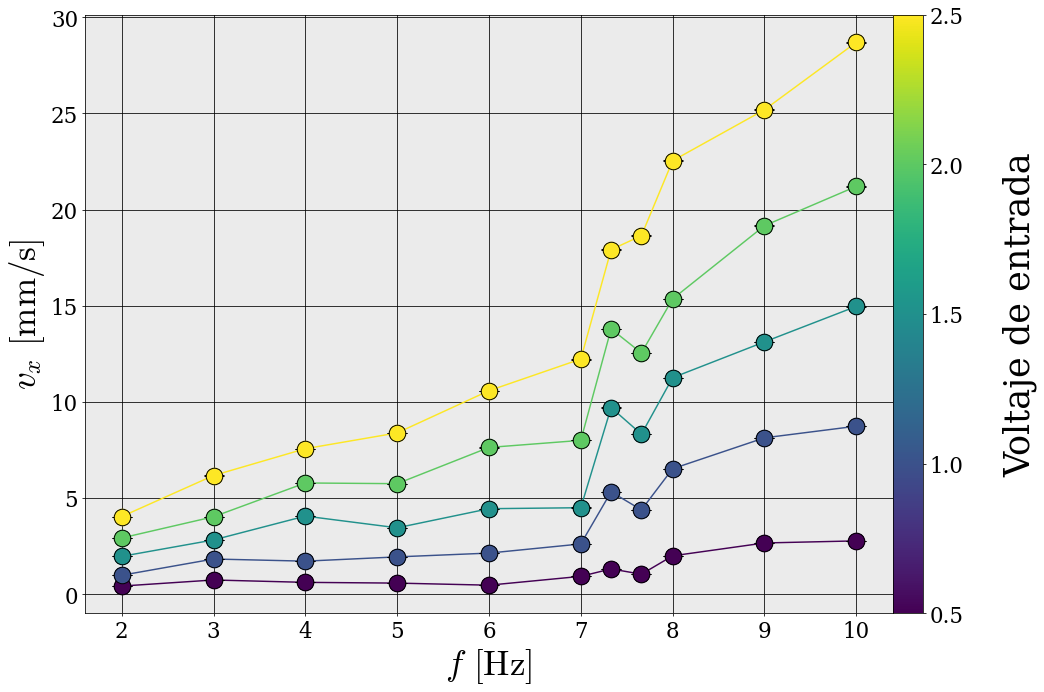

In [226]:
fig,ax = plt.subplots()
for i,vval in enumerate(VOLT_ARRAY_VALUES):
    values = np.array([values_dict[currHz][i] for currHz in currHz_array])
    errors = np.array([error_dict[currHz][i] for currHz in currHz_array])
    ax.plot(FREQ_ARRAY_VALUES,np.abs(values), 'o-', ms=17, color=cmap_v(norm_v(vval)))
    ax.errorbar(FREQ_ARRAY_VALUES, np.abs(values), markerfacecolor = cmap_v(norm_v(vval)), fmt='o',
            yerr = errors, xerr = None, color = 'k', ecolor = 'k',
            ms=17, elinewidth=2, lw=3, capsize=10)

    
ax.set_xlabel(f'$f$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

# cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0)
# cbar_term.ax.set_ylim(0.5,2.5)
# cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
# cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)

# ax.set_xlim([1.7,10.3])
# ax.set_ylim([0,30])

fig.tight_layout()
fig.savefig('gráficos\\slope(f,V).png')




### Pendiente en función de frecuencia